# Análisis deudores BCRA (parte 1)
## mayo de 2020

Autor: Carlos A. Crespo (lvccrespo@gmail.com)

El Banco Central de la República Argentina actualiza mensualmente información respecto a la totalidad de deudores del sistema financiero. Esta información es pública y se conforma con los datos que mensualmente envían las entidades financieras en base a su contabilidad.

Cabe aclarar, que los datos son publicados por dos años más desde la cancelación de cualquier deuda o por cinco años desde que la deuda entró en mora (artículo 26 inciso 4, de la Ley 25.326 de Protección de Datos Personales y su decreto reglamentario).

Para más información: https://www.bcra.gob.ar/BCRAyVos/Situacion_Crediticia.asp

Hemos descargado la información a febrero 2020, así que ¡manos a la obra!

## Procesamiento previo
Contamos con un archivo _"deudores.txt"_ que pesa **4.57 GB**. ***Cargar directamente toda esa info en memoria haría explotar todo*** así que vamos a levantar un pequeño dataset de prueba para revisar la información.

Repasando los metadatos de la base, hemos decidido:
- quedarnos con las columnas __"entidad"__, __"cuitcuil"__, __"totalprestamos"__ (el resto de los campos se descartan)
- el archivo contempla la deuda tanto de personas físicas como de __empresas__. Haremos foco en estás últimas.

In [1]:
import pandas as pd

col_specification =[(0, 5), (13, 24), (29, 41)] # los valores corresponden al punto de inicio y corte de cada campo
nombres_columnas = ["entidad", "cuitcuil", "totalprestamos"]
test = pd.read_fwf('deudores.txt',  nrows = 200, colspecs=col_specification, 
                     header=None,index=False, names = nombres_columnas)

print(test)

     entidad     cuitcuil totalprestamos
0          7  20024515916           15,0
1          7  20017364643           21,0
2          7  20005717621          214,0
3          7  20017290313            2,0
4          7  20002534410            4,0
..       ...          ...            ...
195        7  20040603051          225,0
196        7  20030273991          129,0
197        7  20033912170           49,0
198        7  20040283677           39,0
199        7  20040247956           13,0

[200 rows x 3 columns]


Para poder manejar el archivo y obtener los datos que requerimos vamos a usar una funcionalidad de pandas que se llama ***chunksize***.
Básicamente lo que hace es partir el archivo original en porciones más chicas (y manipulables para nuestra vieja y querida PC).

In [2]:
size = 10 ** 5 # tamaño del chunk. Esto es, cuántas filas va a contener cada "porción" del archivo original

df_chunk = pd.read_fwf('deudores.txt', chunksize=size, colspecs=col_specification,
                       header=None,index=False, names = nombres_columnas)

Ya tenemos las columnas que necesitamos.

Ahora vamos a quedarnos sólamente con las personas jurídicas.
Sabemos que en Argentina el CUIT permite identificar inequívocamente si se trata de una persona física o jurídica: aquellos que empiezan con 30, 33 y 34 corresponden a empresas.

In [3]:
chunk_list = [] # en esta lista vamos a alojar cada chunk que vamos iterando

for chunk in df_chunk:  
    # Nos quedamos sólo con personas jurídicas
    chunk_filter = chunk[chunk["cuitcuil"].astype(str).str[:2].isin(["30","33","34"])]
    chunk_list.append(chunk_filter)
    
# Concatenamos los datos filtrados en un DataFrame 
df = pd.concat(chunk_list)

# Sabemos que los valores de totalprestamos corresponden a miles de pesos con un decimal. 
# Ajustamos para poder procesar adecuadamente y pasamos a $ MM.

df.totalprestamos = df.totalprestamos.str.replace(",",".").astype(float) / 1000

# Exportamos el dataset definitivo
df.to_csv("deudores_juridicas_202002.csv") #ya no tenemos que repetir el proceso.

Al momento de crear "chunk_filter" podríamos haber considerado la siguiente fórmula ```"cuitcuil > 30000000000"```

**¿Por qué no filtrar los casos de esa manera?**

- La información **nos llega directamente como "string"** y podemos manipularla como "string". **¿Qué ganancia hay en cambiar eso?**
- **¿Y si hay cuitcuils que no son exclusivamente numéricos?** Cualquier paso en falso nos va a consumir mucho tiempo (no nos olvidemos que es un .txt de casi 5 GB). Tampoco tanto tiempo! pero regalarlo así... :P

## Trabajamos con los datos
Como primer análisis exploratorio queremos visualizar los datos resumiéndolos por entidad.

Nos interesa obtener deuda total, promedio de deuda, el coeficiente de variación ([CV](https://es.wikipedia.org/wiki/Coeficiente_de_variaci%C3%B3n)) y la cantidad de empresas por entidad.

In [4]:
# Calculo de agregados
df = df.groupby('entidad').agg({'totalprestamos':['sum', 'mean', 'std'] , 'cuitcuil': 'nunique'})

In [5]:
# Ajustamos "etiquetas" de columnas para visualizar mejor
df = df.reset_index()
df.columns = ["entidad", "Prestamos Total en $ MM", "Promedio Deuda en $ MM", "sd", "Cantidad de empresas"]

In [6]:
# Cálculo Coeficiente de Variación
df['CV'] = df[df.columns[3]]  / df[df.columns[2]]

Para simplificar la visualización nos quedamos con las 15 instituciones con mayor deuda consolidada y añadimos etiquetas correspondientes.

In [7]:
df = df.sort_values(by = df.columns[1], ascending = False)[0:14]

# pasar nombres de entidades
df["entidad"].replace({7: "Galicia",
                   11: "Nación",
                   14: "Bapro",
                   15: "ICBC",
                   16: "Citi",
                   17: "BBVA",
                   27: "Supervielle",
                   29: "Ciudad",
                   34: "Patagonia",
                   72: "Santander",
                   150: "HSBC",
                   191: "Credicoop",
                   259: "Itaú",
                   285: "Macro",
                   300: "BICE"}, inplace = True)

## Visualización preliminar y algunas preguntas
Ya estamos en condiciones de poder ver algunos resultados preliminares.

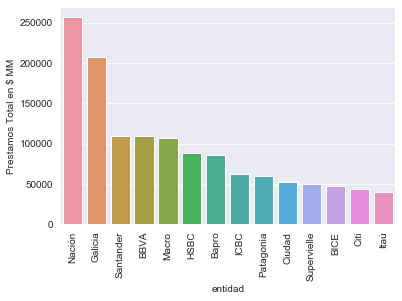

In [8]:
import seaborn as sns
%matplotlib inline

sns.set_style("darkgrid")

g = sns.barplot(x='entidad', y='Prestamos Total en $ MM', data=df)
g.set_xticklabels(g.get_xticklabels(), rotation=90); # el ";" evita texto en el output

¿Cuál es el banco con mayor volumen de deuda? **Nación.**

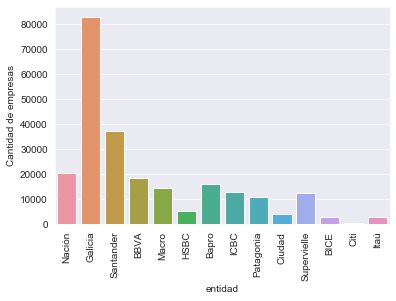

In [9]:
g = sns.barplot(x='entidad', y='Cantidad de empresas', data=df)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

¿Cuál es el banco con mayor cantidad de empresas deudoras? **Galicia.**

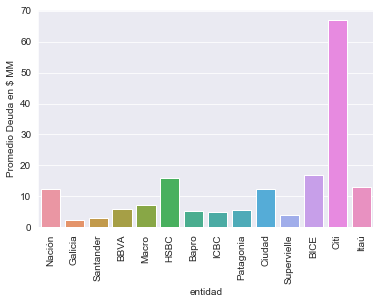

In [10]:
g = sns.barplot(x='entidad', y='Promedio Deuda en $ MM', data=df)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

¿Cuál es el banco con el promedio más alto de deuda? **Citi.**

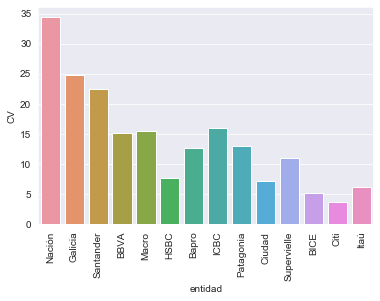

In [11]:
g = sns.barplot(x='entidad', y='CV', data=df)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

¿Hay algún banco que se destaque en términos de mayor variabilidad de montos? **Nación.**
En este punto podríamos suponer que a mayor variabilidad, más "universal" es su oferta: realiza pequeños, medianos y grandes prestamos.

## Interrogantes finales
¿Hay datos que estén sesgando los resultados? Llama la atención los valores extremos de Citi y Galicia. 

¿Cómo podemos visualizar esta información de una manera más atractiva y directa? ¿podemos combinar los indicadores?

¿Cuál será el comportamiento si agrupamos las empresas por actividad? ¿y por región?

¿Podemos armar series históricas e identificar tendencias de mediano / largo plazo?

Te invito a que sumes más preguntas... Muchas gracias!